#Instalação de pacotes

In [ ]:
!python -m textblob.download_corpora

!pip install googletrans-temp

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
  Created wheel for googletrans-temp: filename=googletrans_temp-2.3.0-cp36-none-any.whl size=15675 sha256=f19e10d03dba0a4f344eef2233554235d0e43d8822d6b72cf7539ca27928dabe
  Stored in directory: /root/.cache/pip/wheels/f3/65/06/0b3e233b0e7f5888c05394b86897d41bd5cf8602db3fc9261e
Succe

#Importar pacotes


In [ ]:
import pandas as pd
import string
import time
import csv
import random
import matplotlib.pyplot as plt
from ast import literal_eval
from textblob import TextBlob
from google.colab import drive

#import para mitigar erro au acessar aux.sentences
import nltk
nltk.download('punkt')

from googletrans import Translator



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


#Baixar dataset

In [ ]:
#baixa o arquivo do dataset para o ambiente colab
!wget "http://tiagodemelo.info/datasets/dataset-v2.dat"



--2020-11-21 17:40:58--  http://tiagodemelo.info/datasets/dataset-v2.dat
Resolving tiagodemelo.info (tiagodemelo.info)... 108.167.188.189
Connecting to tiagodemelo.info (tiagodemelo.info)|108.167.188.189|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89773865 (86M)
Saving to: ‘dataset-v2.dat.1’

dataset-v2.dat.1    100%[===================>]  85.61M  15.4MB/s    in 7.0s    

2020-11-21 17:41:06 (12.2 MB/s) - ‘dataset-v2.dat.1’ saved [89773865/89773865]



In [ ]:
# ler o arquivo com dos dados do dataset baixado
file = open("./dataset-v2.dat",'r')

# sepera em linhas os dados
rows = file.readlines()

# fecha o arquivo
file.close()

# criar uma lista para salvar os dicionarios
dictionaries = []

for row in rows:
  #transforma literal em dicionario
  saveDic = literal_eval(row)

  #adiciona atributos de subdicionarios no dicionario mais externo
  saveDic.update(saveDic['itemReviewed'].items())
  saveDic.update(saveDic['itemReviewed']['address'].items())

  # #delete subdicionarios
  del saveDic['address']
  del saveDic['itemReviewed']

  #adiciona na lista de dicionarios
  dictionaries.append(saveDic)




In [ ]:
# transforma a lista de dicionario em dataframe
data = pd.DataFrame(dictionaries)

data.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,name,website,email,phoneNumber,averageRating,streetAddress,addressLocality,addressRegion,postalCode,country
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil


# Obter Comentarios


In [ ]:
# listagens de comentarios
comments_blob = []

#Obter lista dos comentários
comentarios = data.reviewBody

# Iteração em cada comentário
for comentario in comentarios:
  # Obter sentenças tratando emojis
  aux = TextBlob(str(comentario).encode('utf-16', 'surrogatepass').decode('utf-16'))
  comments_blob.append(aux)

#Obter sentenças

In [ ]:
# criar uma lista para  salvar sentenças //salvar os blobs//
comentario_blob = []
sentences_pt = []

# Iteração em cada review
for aux in comments_blob:
  for sentence in aux.sentences:
    # elimina sentenças irrelevantes
    if sentence != "!" and sentence != "." and sentence != ".." and sentence != "rs" and sentence != "Aff." :
      comentario_blob.append(sentence)
      sentences_pt.append(sentence)

comentario_blob[:10]


[Sentence("Comida maravilhosa, lugar do verdadeiro chiclete de camarão."),
 Sentence("O garçom Éric Lima nos atendeu muito bem, pretendemos voltar assim que possível."),
 Sentence("Comida boa, drinks legais e um ambiente bem aconchegante."),
 Sentence("Provamos muitas coisas e tudo nos agradou."),
 Sentence("Principalmente um pato servido em um dos pratos da casa, sensacional!"),
 Sentence("Excelente pra ir com a família!"),
 Sentence("Ótima Comida, ambiente agradável, bom atendimento e estacionamento."),
 Sentence("Vale a pena conhecer"),
 Sentence("Tomo sorvete na Visabor faz mais de 30 anos."),
 Sentence("Sabores de frutas ou artificiais.")]

#Preparação de Comentários

Montar drive.

In [ ]:
drive.mount('/content/drive/', force_remount='true')

Mounted at /content/drive/


Abrir documento criado para receber comentários. 

In [ ]:
!ls -la 'drive/My Drive/sentiment_analysis_project/'

drive_file = "drive/My Drive/sentiment_analysis_project/translate.csv" 
file = open(drive_file,'r')

data_translate = pd.read_csv(file)

total 76602
-rw------- 1 root root    16570 Nov 20 15:07 ground_truth.csv
-rw------- 1 root root      151 Nov 21 14:57 ground_truth.gsheet
-rw------- 1 root root 26857618 Nov 11 02:52 translate.csv
-rw------- 1 root root 51564867 Nov 14 19:48 translate_us.csv


Iterar sobre cada comentário e adicionar ao arquivo a coluna 'review_us' com valor 'EMPTY'.

In [ ]:
# Iteração em cada review
for cmt in comentarios:
  try:
    #Obter sentenças tratando emojis
    comment_aux = str(cmt).encode('utf-16', 'surrogatepass').decode('utf-16')
    #cria objeto para adicionar ao dataframe
    obj_aux = { 'review': comment_aux, 'review_us': 'EMPTY' }
    # adiciona ao dataframe
    data_translate = data_translate.append(obj_aux, ignore_index=True)
  except:
    print("exception: " + cmt)


Salvar arquivo

In [ ]:
# Salva arquivo no google Drive
data_translate.to_csv(drive_file, index=False, header=True)    
data_translate

#Traduzir comentários

Realizamos a cópia do arquivo preparado e renomeamos para o arquivo 'translate_us' que recebeu a tradução de cada comentário

Montar drive.

In [ ]:
drive.mount('/content/drive/', force_remount='true')

Mounted at /content/drive/


Abrir arquivo

In [ ]:
drive_file = "drive/My Drive/sentiment_analysis_project/translate_us.csv" 
data_translate = pd.read_csv(drive_file)

Selecionar apenas comentários que ainda não foram traduzidos

In [ ]:
dt = data_translate.loc[data_translate['review_us'] == 'EMPTY']

#Informação sobre quantos faltam para finalizar tradução
print(dt.describe())

Traduzir comentários para Inglês (US) informando quantas iterações deseja realizar.

Quantidade/Minutos

---
>  500 / 4,5

> 1000 / 8,9   

> 1500 / 13,51

> 3000 / 26,86

> 5000 / 44,73



In [ ]:
#@title Iterações
Quantidade =  500#@param {type:"integer"}
#Obter lista dos comentários
comentarios = dt.review

Iterar quantidade informada e executar tradução a cada 0,5 segundos

In [ ]:
for comentario in comentarios[:Quantidade]:
  try:
    time.sleep(0.5)
    # Obter sentenças tratando emojis
    txt_blob_aux = TextBlob(str(comentario).encode('utf-16', 'surrogatepass').decode('utf-16'))
    aux_us = str(txt_blob_aux.translate(to='us'))
    print(aux_us)

    # Atualiza dataframe na exata posição do comentário em português 
    data_translate.at[(data_translate['review'] == comentario), 'review_us'] = aux_us
  except:
    print("EXCEPTION: " + str(txt_blob_aux))
    # Detecta se a exceção ocorreu devido a linguagem do comentário já ser inglês
    if txt_blob_aux.detect_language() == 'en':
      data_translate.at[(data_translate['review'] == comentario), 'review_us'] = str(txt_blob_aux)
      print("Up-to-date: " + str(txt_blob_aux))
      


# Salva arquivo no google Drive ao finalizar iterações
data_translate.to_csv(drive_file, index=False, header=True)

data_translate

#Preparar dataset principal
Adicionar tradução, dados de classificação e subjetividade.


Montar drive

In [ ]:
drive.mount('/content/drive/', force_remount='true')

Abrir arquivo

In [ ]:
file_translated = "drive/My Drive/sentiment_analysis_project/translate_us.csv" 
data_translate = pd.read_csv(file_translated)

Preparar novas colunas

In [ ]:
array_translated = []
array_subjectivity = []
array_polarity = []

# Declarado na célula 'Baixar dataset'
for index, row in data.iterrows():
  # Obter review traduzido
  str_us = str(data_translate.iloc[index]['review_us']).encode('utf-16', 'surrogatepass').decode('utf-16')
  # Obter textblob para pegar informações de subjetividade e polaridade
  aux = TextBlob(str_us)

  array_translated.append(str_us)
  array_subjectivity.append(aux.sentiment.subjectivity)
  array_polarity.append(aux.sentiment.polarity)


Adicionar colunas


1.   Texto traduzido = 'reviewTextBlob'
2.   Subjetividade = 'subjectivity'
1.   Polaridade = 'polarity'






In [ ]:
data.insert(0, 'reviewTextBlob', array_translated)
data.insert(0, 'subjectivity', array_subjectivity)
data.insert(0, 'polarity', array_polarity)

data

,polarity,subjectivity,reviewTextBlob,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,name,website,email,phoneNumber,averageRating,streetAddress,addressLocality,addressRegion,postalCode,country
0,0.350000,0.650000,"Wonderful food, the place for real shrimp gum....",Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil
1,0.410476,0.820238,"Good food, nice drinks and a very cozy atmosph...",Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil
2,0.706667,0.683333,"Excellent to go with the family! Great food, p...",Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,0.103333,0.712381,I have had ice cream at Visabor for over 30 ye...,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil
4,0.575000,0.608333,The best hamburger I've ever eaten! Excellent ...,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.018333,0.328333,"Not yet officially opened, it is serving in so...",Nova opção no Paseo!!!,672210394,17424548,Fabiano B,"Ainda não inaugurado oficialmente, está atende...",pt,True,"Porto Alegre, RS",07/05/2019,05/2019,5,Boteco Maestro,http://www.facebook.com/botecomaestro,None,+55 51 99353-6602,4.0,Avenida Wenceslau Escobar 1823,Porto Alegre,Rio Grande do Sul,91900-000,Brasil
99996,0.227083,0.533333,"Good service, beautiful place, very tasty food...",Bom,380904400,2440184,Chris L,"Bom atendimento, lugar bonito, comida muito go...",pt,True,"Cork, Irlanda",08/06/2016,01/2016,4,Casa do Marquês,http://galeteriacasadomarques.com.br/,galeteriacasadomarques@galeteriacasadomarques....,+55 51 3343-4303,4.5,"Rua Marques do Pombal, 1814 Higienópolis",Porto Alegre,Rio Grande do Sul,90540-000,Brasil
99997,0.048661,0.525446,Rio Scenarium is one of the most famous ballad...,Bom bar,186111858,2392996,Guilherme P,O Rio Scenarium é uma das baladas mais famosas...,pt,False,"São Paulo, SP",27/11/2013,11/2013,4,Rio Scenarium,http://www.rioscenarium.art.br,None,+55 21-3147-9000,4.5,Rua do Lavradio 20 Centro,Rio de Janeiro,Estado do Rio de Janeiro,20230-070,Brasil
99998,0.002143,0.569143,I went by indication and with good expectation...,Me senti enganada...,152745909,1062290,LisianeCohem,"Fui por indicação e com boa expectativa!\n116,...",pt,True,"Porto Alegre, RS",21/02/2013,None,2,Celeiro,http://www.celeiroculinaria.com.br,celeiro@celeiroculinaria.com.br,55 21 2274 7843,3.5,Rua Dias Ferreira 199,Rio de Janeiro,Estado do Rio de Janeiro,22431-050,Brasil


Salvar arquivo

In [ ]:
data.to_csv('drive/My Drive/sentiment_analysis_project/main.csv', index=True, header=True, encoding='utf-16', errors='surrogatepass')

#Gerar Senteças aleatórias

Gerar 200 index aleatorios não repetidos

In [ ]:
indexRandom = []

while len(indexRandom) < 200:
  n = random.randint(0, len(comments_blob) -1)
  if not n in indexRandom:
    indexRandom.append(n)

len(indexRandom)

200

Gerar lista com as sentenças

In [ ]:
list_sentences = [];

for i in indexRandom:
  if len(list_sentences) == 200:
      break
  # Descomentar somente se tiver sido feito a traducao no 'comments_blob_us'
  # for sentence_br, sentence in zip(comments_blob_limite[i].sentences, comments_blob_us[i].sentences):
  for sentence_br in comments_blob[i].sentences:
    newSentence = {
        "sentence_pt": str(sentence_br).encode('utf-16', 'surrogatepass').decode('utf-16'),
        # "sentence_us": str(sentence).encode('utf-16', 'surrogatepass').decode('utf-16'),
        # "subjectivity": sentence.sentiment.subjectivity,
        # "subjectivity": sentence.sentiment.polarity,
        # "index_comment": i
    }
    list_sentences.append(newSentence)
    if len(list_sentences) == 200:
      break

len(list_sentences)

Salvar lista no formato **csv**

In [ ]:
#datasete sentences
dtSentence = pd.DataFrame(list_sentences)

dtSentence.head()

dtSentence.to_csv(r'sentences.csv')

#Etapa I

Distribuição de polaridade

Baixar dataset

In [ ]:
!wget https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/main.zip?raw=true

--2020-11-25 03:54:59--  https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/main.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/main.zip [following]
--2020-11-25 03:54:59--  https://github.com/Andrewsas/trabalho-fundamentos-cid/raw/master/data/main.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/main.zip [following]
--2020-11-25 03:54:59--  https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/main.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|

In [ ]:
#Ler arquivo
data = pd.read_csv('/content/main.zip', compression='zip', encoding='utf-16')

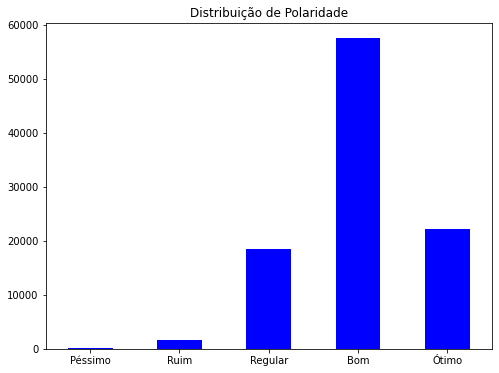

In [ ]:
#Gráfico
prob = pd.Series(data['polarity'])

out = pd.cut(prob, bins=5, include_lowest=True)
graph = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(8,6))
graph.set_xticklabels(['Péssimo','Ruim', 'Regular', 'Bom', 'Ótimo'])
graph.set_title('Distribuição de Polaridade')
plt.show()

Pesquisa para determinar o menor valor ***subjetivo***

In [ ]:
#@title Valores mínimos para comentário factual
min_value = 0.46 #@param {type:"number"}
max_value = 0.47 #@param {type:"number"}
df = data[(data['subjectivity'] >= min_value) & (data['subjectivity'] <= max_value)]
df = df.get(['subjectivity', 'reviewBody'])

df

,subjectivity,reviewBody
19,0.467708,Esse restaurante está situado na avenida Conde...
78,0.468750,Já tinhamos ido no Jamies Italian de Londres e...
213,0.469643,"Fui ã noite, e embora sabia que estava bem pro..."
308,0.464762,Local muito agradável garçons atenciosos e o r...
311,0.466667,Estive no café Viriato em duas oportunidades n...
...,...,...
99925,0.466667,Um dos melhores gorduroso que já comi digno de...
99957,0.464583,Comemoramos.o aniversário da minha irmã la dia...
99965,0.461250,"Acredito que o melhor restaurante de Teresina,..."
99976,0.461364,"é um lugar típico, tanto pra quem está a passe..."


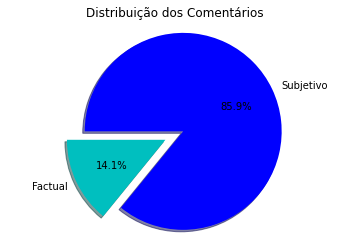

In [ ]:
prob = pd.Series(data['subjectivity'])

out = pd.cut(prob, bins=[0, min_value, 1], include_lowest=True)
graph = out.value_counts(sort=False)
cols = ['Factual','Subjetivo']
color_array = ['c','b']

plt.pie(graph,
        labels=cols,
        colors=color_array,
        startangle=180,
        shadow= True,
        explode=(0,0.2),
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribuição dos Comentários')

plt.show()

# Ground Truth Comparativo



In [ ]:

fonte = "https://github.com/Andrewsas/trabalho-fundamentos-cid/blob/master/data/ground_truth.csv?raw=true"

dt_ground = pd.read_csv(fonte)
dt_ground.columns = ['comments_pt', 'subjectivity', 'polarity']
dt_ground.head()

,comments_pt,subjectivity,polarity
0,"comida excelente, atendimento bom é perto do c...",NaN,NaN
1,Parabens Camarada!,NaN,NaN
2,"Restaurante fantástico, ambiente aconchegante,...",NaN,NaN
3,O restaurante possui um espaço kids muito segu...,NaN,NaN
4,O preço cobrado é justo.,NaN,NaN


# Translate Google

In [ ]:
translator = Translator()
df = pd.DataFrame({'Spanish':['piso','cama']})
df

,Spanish
0,piso
1,cama


In [ ]:
dt_ground['comments_us'] = dt_ground['comments_pt'].apply(translator.translate, src='auto', dest='en').apply(getattr, args=('text',))
dt_ground.head()

,comments_pt,subjectivity,polarity,comments_us
0,"comida excelente, atendimento bom é perto do c...",NaN,NaN,"Excellent food, good service is close to the a..."
1,Parabens Camarada!,NaN,NaN,"Congratulations, comrade!"
2,"Restaurante fantástico, ambiente aconchegante,...",NaN,NaN,"Fantastic restaurant, Cozy atmosphere, Wonderf..."
3,O restaurante possui um espaço kids muito segu...,NaN,NaN,The restaurant has a very safe and comfortable...
4,O preço cobrado é justo.,NaN,NaN,The price charged is fair.


# Cálculo da subjetividade

In [ ]:
# coloquei para teste, uso as sentenças dos dez primeiros comentarios
# O valor da subjetividade é um número real entre [0.0, 1.0], onde 0.0 o texto é indicado como muito objetivo e 1.0 o texto é indicado como muito subjetivo.
for i in range(10):
  for sentence_br, sentence in zip(comments_blob_limite[i].sentences, comments_blob_us[i].sentences):
    print(sentence_br, ':', sentence.sentiment.subjectivity)

# Cálculo da polaridade

In [ ]:
# coloquei para teste, uso as sentenças dos dez primeiros comentarios
# O valor da polaridade é um número real entre os valores [-1.0, 1.0].
for i in range(10):
  for sentence_br, sentence in zip(comments_blob_limite[i].sentences, comments_blob_us[i].sentences):
    print(sentence_br, ':', sentence.sentiment.polarity)

Obter dataset traduzido com textblob e gerar sentenças aleatórias para o ***ground-truth***/

#Analise Exploratória

In [ ]:
!git clone "https://github.com/Andrewsas/trabalho-fundamentos-cid.git"

Cloning into 'trabalho-fundamentos-cid'...
remote: Enumerating objects: 70, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 70 (delta 19), reused 19 (delta 4), pack-reused 0
Unpacking objects: 100% (70/70), done.


In [ ]:
!unzip ./trabalho-fundamentos-cid/data/main.zip

Archive:  ./trabalho-fundamentos-cid/data/main.zip
  inflating: main.csv                


In [ ]:
dt_traduzido = pd.read_csv("./main.csv", encoding = 'utf-16')


In [ ]:
dt_traduzido.head()

,Unnamed: 0,polarity,subjectivity,reviewTextBlob,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,name,website,email,phoneNumber,averageRating,streetAddress,addressLocality,addressRegion,postalCode,country
0,0,0.350000,0.650000,"Wonderful food, the place for real shrimp gum....",Jantar,692856288,2344932.0,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,NaN,Alagoas,57030-170,Brasil
1,1,0.410476,0.820238,"Good food, nice drinks and a very cozy atmosph...",Uma boa experiência.,229208487,3720906.0,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,NaN,Rio Grande do Norte,59092-100,Brasil
2,2,0.706667,0.683333,"Excellent to go with the family! Great food, p...",Otimo self service,679002332,2248105.0,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,3,0.103333,0.712381,I have had ice cream at Visabor for over 30 ye...,O sorvete mais tradicional do estado,355671519,8168302.0,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,NaN,Brasil
4,4,0.575000,0.608333,The best hamburger I've ever eaten! Excellent ...,Melhor hamburger!,268741921,5395141.0,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

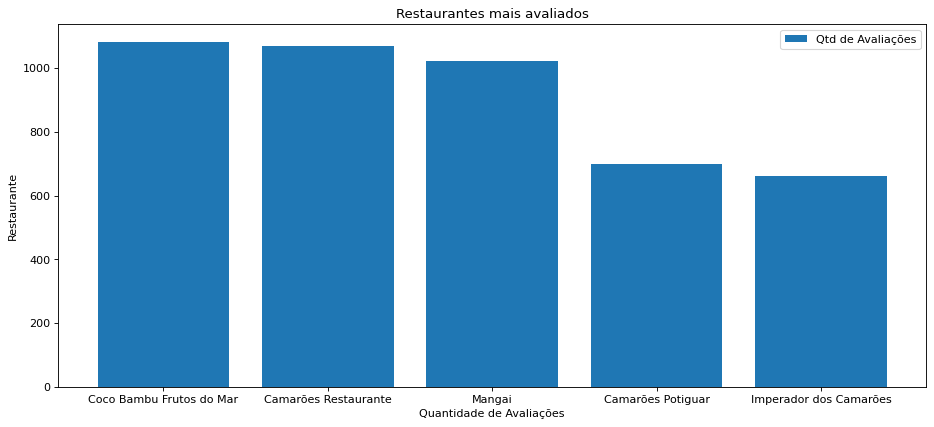

In [ ]:
# 5 restaurante mais avaliados

figure(num=None, figsize=(14, 6), dpi=80)

rowValues = dt_traduzido['name'].value_counts().sort_values(ascending=False)[:5].values
colRestaurante = dt_traduzido['name'].value_counts().sort_values(ascending=False)[:5].index

plt.bar(colRestaurante, rowValues, label="Qtd de Avaliações")

plt.legend()

plt.xlabel('Quantidade de Avaliações')
plt.ylabel('Restaurante')

plt.title('Restaurantes mais avaliados')

plt.show()

In [ ]:
dt_traduzido['name'].value_counts().sort_values(ascending=False)[:5].values

array([1083, 1068, 1023,  699,  661])

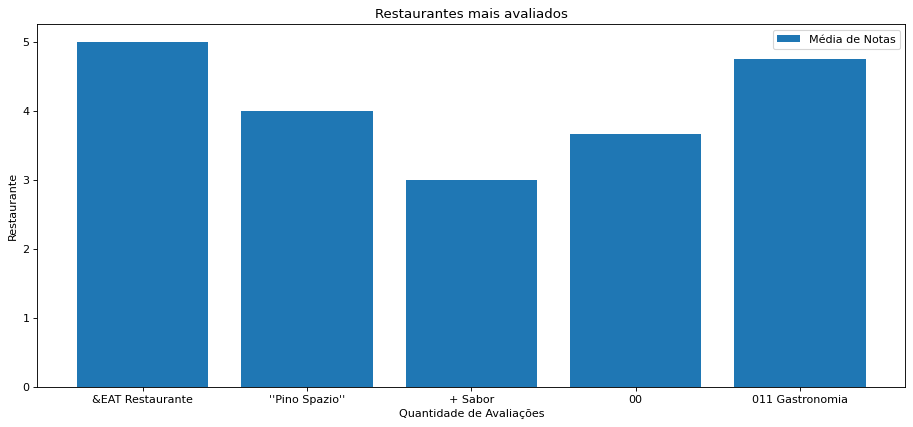

In [ ]:
# 5 restaurante com maiores notas

figure(num=None, figsize=(14, 6), dpi=80)

rowValues = dt_traduzido.groupby("name").mean()["ratingValue"][:5].values
colRestaurante = dt_traduzido.groupby("name").mean()["ratingValue"][:5].index

plt.bar(colRestaurante, rowValues, label="Média de Notas")

plt.legend()

plt.xlabel('Quantidade de Avaliações')
plt.ylabel('Restaurante')

plt.title('Restaurantes mais avaliados')

plt.show()


In [ ]:
#comparação das avaliações do coco bambum por quarter nos ultimos anos

serie_coco =  dt_traduzido.query("name == 'Coco Bambu Frutos do Mar'").groupby("publicationDate").size()
dt_coco = pd.DataFrame({'date':serie_coco.index, 'qtd':serie_coco.values})
dt_coco['date'] = pd.to_datetime(dt_coco['date'])
dt_coco['quarter'] = dt_coco['date'].dt.quarter

dt_coco2020 = dt_coco[dt_coco['date'].dt.strftime('%Y') == '2020']
dt_coco2019 = dt_coco[dt_coco['date'].dt.strftime('%Y') == '2019']
dt_coco2018 = dt_coco[dt_coco['date'].dt.strftime('%Y') == '2018']
dt_coco2017 = dt_coco[dt_coco['date'].dt.strftime('%Y') == '2017']

quarter2020 = dt_coco2020.groupby("quarter").size().sort_index()
quarter2019 = dt_coco2019.groupby("quarter").size().sort_index()
quarter2018 = dt_coco2018.groupby("quarter").size().sort_index()
quarter2017 = dt_coco2017.groupby("quarter").size().sort_index()

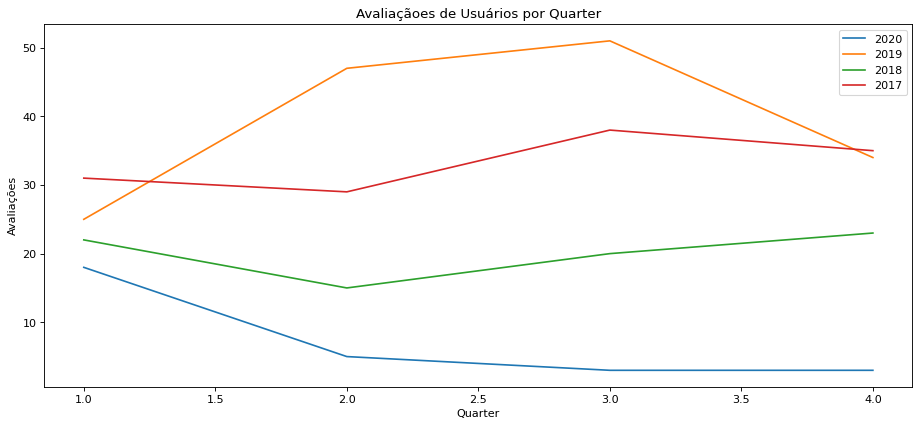

In [ ]:

figure(num=None, figsize=(14, 6), dpi=80)

plt.plot(quarter2020.index, quarter2020.values, label="2020")
plt.plot(quarter2019.index, quarter2019.values, label="2019")
plt.plot(quarter2018.index, quarter2018.values, label="2018")
plt.plot(quarter2017.index, quarter2017.values, label="2017")

plt.legend()

plt.xlabel('Quarter')
plt.ylabel('Avaliações')

plt.title('Avaliaçãoes de Usuários por Quarter')

plt.show()

**Montar Drive**

In [1]:
drive.mount('/content/drive/', force_remount='true')

NameError: ignored

**Gerando o valor de subjetividade das sentenças do gabarito**

In [ ]:
drive_file = "drive/my-drive/sentenca_subjetividade.csv" 
#Carregando sentencas do gabarito
url = 'https://raw.githubusercontent.com/Andrewsas/trabalho-fundamentos-cid/master/data/somente_sentencas.csv'
#Atribuindo sentencas no dataframe df
df = pd.read_csv(url)
#Percorrendo sentencas
for row in df:
  try:
    #Transformando em Blob
    comentario = TextBlob(row)
    #Traduzindo para ingles
    comentario_us = comentario.translate(to='us')
    #Calculando subjetividade da sentenca
    for sentence_br, sentence in zip(comentario.sentences, comentario_us.sentences):
      #cria objeto para adicionar ao dataframe
      obj_aux = { 'Comentario': comentario, 'Subjetividade': sentence.sentiment.subjectivity }
      #adiciona ao dataframe
      df = df.append(obj_aux, ignore_index=True)
  except:
    print('exception', row)

    comida excelente. atendimento bom é perto do centro administrativo e de fácil acesso. ambiente climatizado.
0                                   Parabens Camarada!                                                         
1    Restaurante fantástico ambiente aconchegante c...                                                         
2    O restaurante possui um espaço kids muito segu...                                                         
3                             O preço cobrado é justo.                                                         
4    Possui um menu de inspiração asiática (tailand...                                                         
..                                                 ...                                                         
194  O restaurante fica de frente para a praia o lu...                                                         
195  Localização na principal rua da cidade sucos ó...                                                  

**Salvar gabarito com a subjetividade no Drive**

In [ ]:
df.to_csv(drive_file, index=False, header=True)    
df